In [315]:
from train_model import load_data

import matplotlib.pyplot as plt
import datetime as dt
import paths

from preprocessing import visualisation

In [324]:
import importlib
importlib.reload(visualisation)

<module 'preprocessing.visualisation' from 'C:\\Users\\aline\\soil-moisture-proxies\\preprocessing\\visualisation.py'>

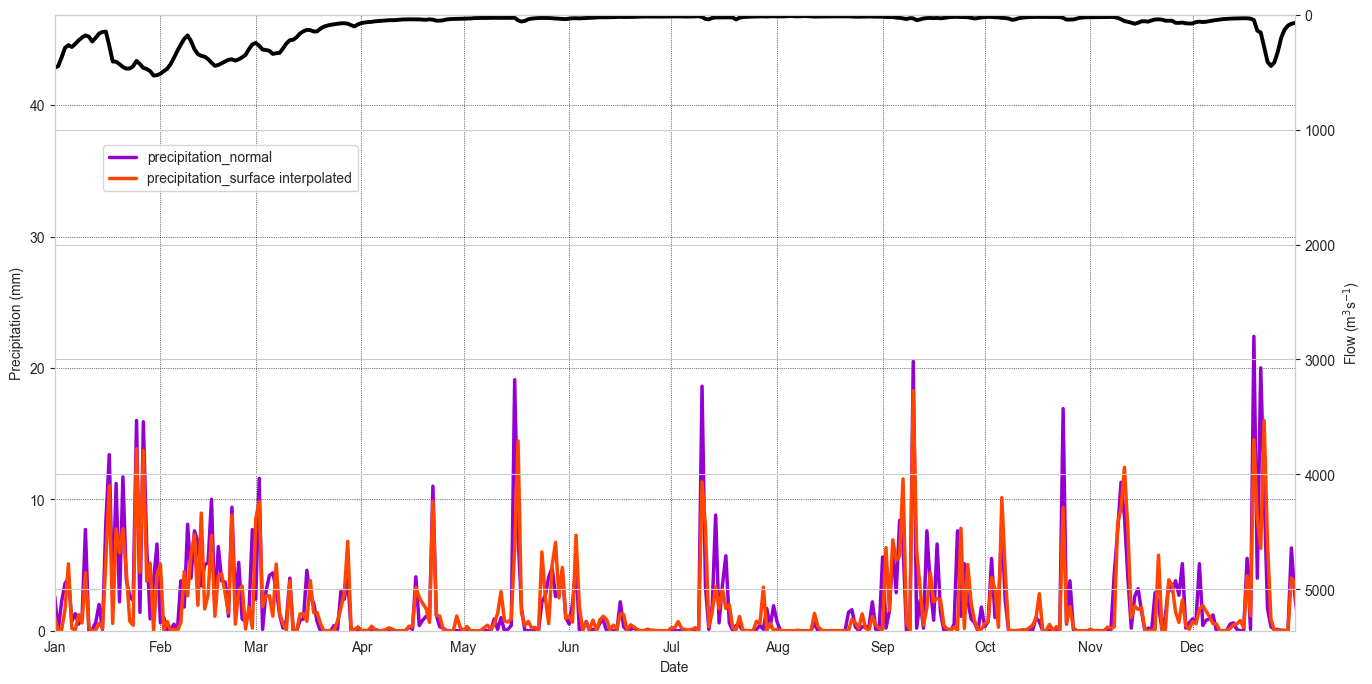

In [326]:
station_nr = 54057

rf = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_linear.csv'), verbose=False)
rf_9to9 =load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_linear.csv'), verbose=False)
rf_9to9_cubic =load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_cubic.csv'), verbose=False)
rf_9to9_nrfa = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_nrfa.csv'), verbose=False)
rf_9to9_interp = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_surf_interp.csv'), verbose=False)
#rf_9to9_interp_01 = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_surf_interp_0.1.csv'), verbose=False)

rf_error_nrfa_era5 = rf_9to9_nrfa[['Rain']] - rf_9to9[['Rain']]

colors = ['darkviolet', 'orangered', 'orange', 'cadetblue']
labels = ['NRFA', 'higher res', 'surface interpolation', 'centroid method', '00h to 00h']

visualisation.compare_precipitation_and_flow(dfs_precipitation=[rf_9to9_nrfa, rf_9to9_interp], 
                                             colors=['darkviolet', 'orangered'],
                                             labels=['normal', 'surface interpolated'],
                                             df_flow=rf_9to9,
                                             year = 1995)

In [9]:
import pandas as pd

df_comparison = rf_9to9_nrfa[['Date', 'Rain']].merge(rf_9to9_interp[['Date', 'Rain']], on='Date')
df_comparison = df_comparison.rename(columns={'Rain_x':'Observation', 'Rain_y':'Reanalysis'})
df_comparison['Error'] = abs(df_comparison['Observation'] - df_comparison['Reanalysis'])
df_comparison['Regime'] = df_comparison['Observation'].apply(lambda obs: 0 if obs < 5 else 1)

df_comparison['Date'] = pd.to_datetime(df_comparison['Date'])
df_comparison['Day'] = df_comparison['Date'].dt.dayofyear

df_comparison

,Date,Observation,Reanalysis,Error,Regime,Day
0,1981-01-31,0.0,1.189391e-02,1.189391e-02,0,31
1,1981-02-01,0.0,-9.757157e-08,9.757157e-08,0,32
2,1981-02-02,5.4,3.659546e-01,5.034045e+00,1,33
3,1981-02-03,0.6,4.821043e+00,4.221043e+00,0,34
4,1981-02-04,0.1,2.101955e-01,1.101955e-01,0,35
...,...,...,...,...,...,...
13356,2017-12-27,2.0,1.845270e+01,1.645270e+01,0,361
13357,2017-12-28,3.8,0.000000e+00,3.800000e+00,0,362
13358,2017-12-29,3.5,5.107012e+00,1.607012e+00,0,363
13359,2017-12-30,3.7,3.035281e+00,6.647186e-01,0,364


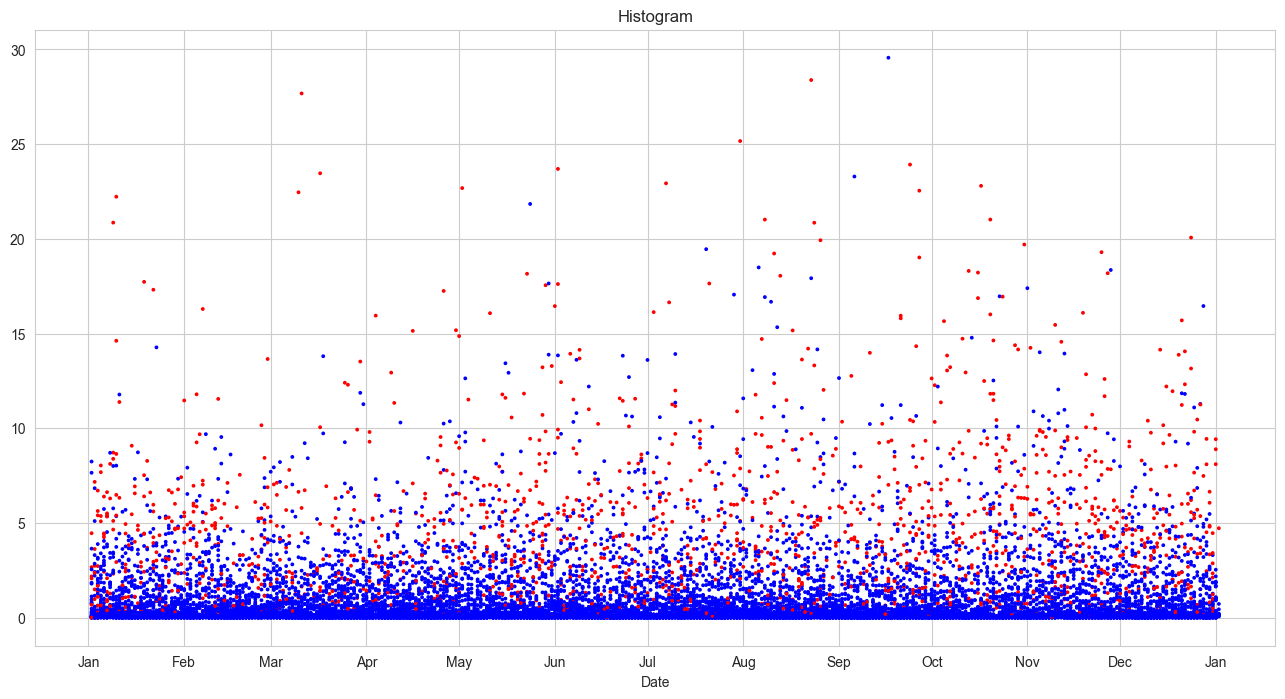

In [11]:
fig, ax1 = plt.subplots(figsize=(16, 8))

colors = df_comparison['Regime'].map({0: 'blue', 1: 'red'})

ax1.scatter(df_comparison['Day'], df_comparison['Error'], c=colors, s=3)
ax1.set_xlabel('Date')
ax1.xaxis.set_major_locator(mdt.MonthLocator())
ax1.xaxis.set_major_formatter(mdt.DateFormatter('%b'))

plt.title('Histogram')
plt.show()

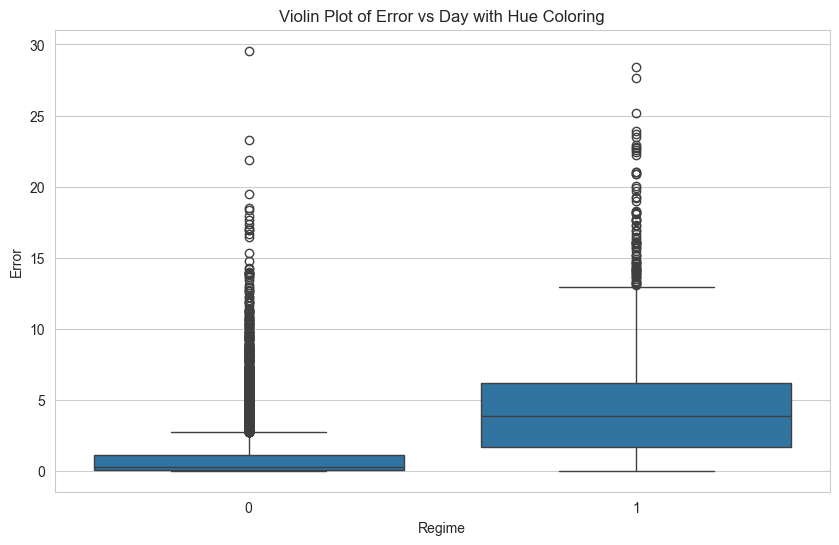

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.boxplot(x='Regime', y='Error', data=df_comparison)
plt.title('Violin Plot of Error vs Day with Hue Coloring')
plt.show()

In [51]:
import pandas as pd

# Assuming dataset1 and dataset2 are pandas DataFrames or Series
print("Dataset 1 Descriptive Statistics:")
print(rf_9to9[['Rain']].describe())

print("Dataset 2 Descriptive Statistics:")
print(rf_9to9_nrfa[['Rain']].describe())

Dataset 1 Descriptive Statistics:
               Rain
count  1.497500e+04
mean   3.075009e+00
std    4.217137e+00
min   -4.163336e-14
25%    2.738417e-01
50%    1.564514e+00
75%    4.179066e+00
max    5.052823e+01
Dataset 2 Descriptive Statistics:
               Rain
count  12962.000000
mean       3.536136
std        5.676834
min        0.000000
25%        0.100000
50%        1.300000
75%        4.500000
max       88.900000


Dataset 1: Mean = 3.09, Std = 4.23
Dataset 2: Mean = 3.54, Std = 5.68


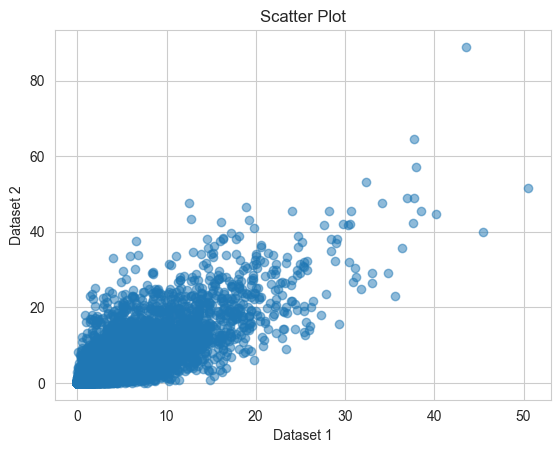

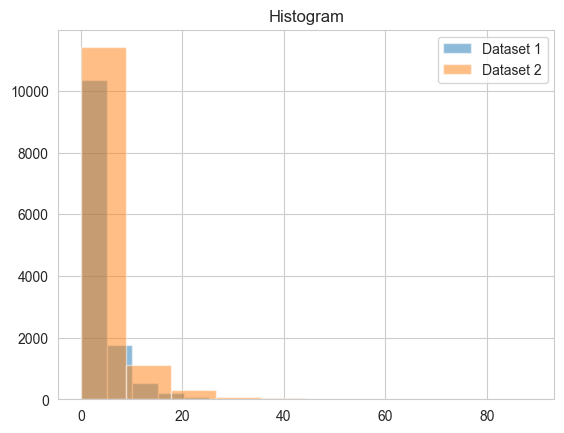

Mean Difference = -0.45, Std of Differences = 3.30
Paired t-test: t-statistic = -15.38, p-value = 0.00


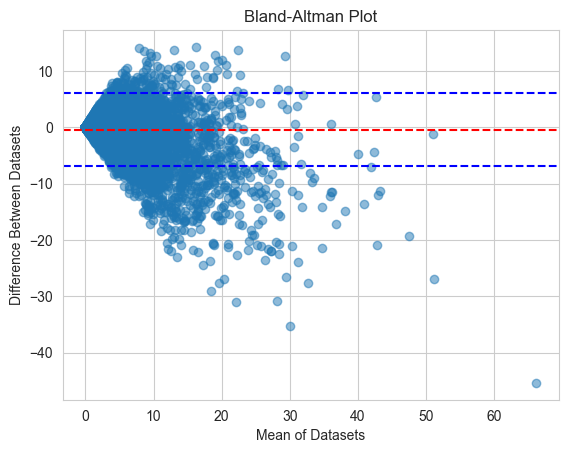

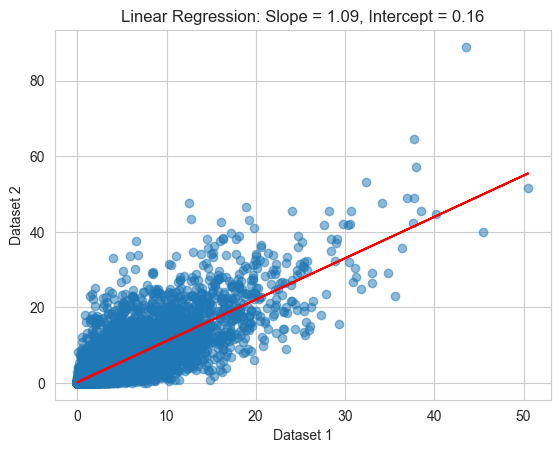

Pearson Correlation = 0.82
Spearman Correlation = 0.85


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

# Example datasets
dataset1 = rf_9to9[552:-1461][['Rain']]
dataset2 = rf_9to9_nrfa[['Rain']]

# Convert to numpy arrays
data1 = dataset1.values.flatten()
data2 = dataset2.values.flatten()

# Descriptive statistics
print(f"Dataset 1: Mean = {np.mean(data1):.2f}, Std = {np.std(data1):.2f}")
print(f"Dataset 2: Mean = {np.mean(data2):.2f}, Std = {np.std(data2):.2f}")

# Scatter plot
plt.scatter(data1, data2, alpha=0.5)
plt.xlabel('Dataset 1')
plt.ylabel('Dataset 2')
plt.title('Scatter Plot')
plt.show()

# Histogram
plt.hist(data1, alpha=0.5, label='Dataset 1')
plt.hist(data2, alpha=0.5, label='Dataset 2')
plt.legend(loc='upper right')
plt.title('Histogram')
plt.show()

# Difference analysis
differences = data1 - data2
print(f"Mean Difference = {np.mean(differences):.2f}, Std of Differences = {np.std(differences):.2f}")

# Paired t-test
t_stat, p_value = stats.ttest_rel(data1, data2)
print(f"Paired t-test: t-statistic = {t_stat:.2f}, p-value = {p_value:.2f}")

# Bland-Altman plot
mean_values = np.mean([data1, data2], axis=0)
plt.scatter(mean_values, differences, alpha=0.5)
plt.axhline(np.mean(differences), color='red', linestyle='--')
plt.axhline(np.mean(differences) + 1.96 * np.std(differences), color='blue', linestyle='--')
plt.axhline(np.mean(differences) - 1.96 * np.std(differences), color='blue', linestyle='--')
plt.xlabel('Mean of Datasets')
plt.ylabel('Difference Between Datasets')
plt.title('Bland-Altman Plot')
plt.show()

# Regression analysis
model = LinearRegression()
model.fit(data1.reshape(-1, 1), data2)
slope = model.coef_[0]
intercept = model.intercept_
plt.scatter(data1, data2, alpha=0.5)
plt.plot(data1, model.predict(data1.reshape(-1, 1)), color='red')
plt.xlabel('Dataset 1')
plt.ylabel('Dataset 2')
plt.title(f'Linear Regression: Slope = {slope:.2f}, Intercept = {intercept:.2f}')
plt.show()

# Correlation
pearson_corr, _ = stats.pearsonr(data1, data2)
spearman_corr, _ = stats.spearmanr(data1, data2)
print(f"Pearson Correlation = {pearson_corr:.2f}")
print(f"Spearman Correlation = {spearman_corr:.2f}")


In [83]:
import pandas as pd
import geopandas as gp
from shapely.geometry import Polygon, Point
from apollo import osgconv as osg
from apollo import hydropoint

In [84]:
# Function to round up based on the sign of the value
def round_to_nearest(value, max=True, base=0.25, buffer=5):
    if max:
        return np.ceil(value/base) * base + buffer*base 
    else: 
        return np.floor(value / base) * base - buffer*base

def extract_raster_to_interpolate(catchment_path, resolution, buffer=5):
  
    boundary = gp.read_file(catchment_path)
    minx, miny, maxx, maxy = boundary.total_bounds
    
    # Convert bounding box coordinates to latitude and longitude
    lat_min, lon_min = osg.BNG_2_latlon(minx, miny)
    lat_max, lon_max = osg.BNG_2_latlon(maxx, maxy)
    
    # Round the bounding box coordinates
    lat_min = round_to_nearest(lat_min, max=False, base=resolution, buffer=buffer)
    lon_min = round_to_nearest(lon_min, max=False, base=resolution, buffer=buffer)
    lat_max = round_to_nearest(lat_max, base=resolution, buffer=buffer)
    lon_max = round_to_nearest(lon_max, base=resolution, buffer=buffer)
        
    return lat_min, lat_max, lon_min, lon_max

In [74]:
def convenient_f(x1, x2, f):
    x = np.vstack((x1.ravel(), x2.ravel())).T
    z = f(x)
    return z.reshape(x1.shape)

def plot_interpolation(x1, x2, z, f):

    X1, X2 = np.meshgrid(x1, x2, indexing='ij') 
    x1_surface, x2_surface = np.meshgrid(np.linspace(x1.min(), x1.max(), len(x1)), np.linspace(x2.min(), x2.max(), len(x2)), indexing='ij')

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.plot(X1.ravel(), X2.ravel(), z.ravel(), "ok")
    ax.plot_surface(x1_surface, x2_surface, convenient_f(x1_surface, x2_surface, f), alpha=0.5)
    plt.show()

In [75]:
from scipy.interpolate import griddata

def fill_non_finite_values(data):
    # Convert the input to a numpy array if it isn't already
    data = np.array(data)
    
    # Check for non-finite values in the data
    if not np.all(np.isfinite(data)):
        data_filled = data.copy()
        
        # Get indices of finite and non-finite values
        finite_idx = np.isfinite(data_filled)
        non_finite_idx = ~finite_idx
        
        # Get coordinates of finite and non-finite values
        x_finite, y_finite = np.where(finite_idx)
        x_non_finite, y_non_finite = np.where(non_finite_idx)
        
        # Get finite values
        finite_values = data_filled[finite_idx]
        
        # Perform interpolation
        interpolated_values = griddata(
            (x_finite, y_finite),
            finite_values,
            (x_non_finite, y_non_finite),
            method='linear'
        )
        
        # For any remaining NaNs after interpolation, use nearest neighbor
        remaining_nans = np.isnan(interpolated_values)
        if np.any(remaining_nans):
            interpolated_values[remaining_nans] = griddata(
                (x_finite, y_finite),
                finite_values,
                (x_non_finite[remaining_nans], y_non_finite[remaining_nans]),
                method='nearest'
            )
        
        # Fill non-finite values with interpolated values
        data_filled[non_finite_idx] = interpolated_values

        return data_filled
    else:
        return data

def fill_non_finite_values(data):
    # Convert the input to a numpy array if it isn't already
    data = np.array(data)
    
    # Check for non-finite values in the data
    if not np.all(np.isfinite(data)):
        data_filled = data.copy()
        
        # Get indices of finite and non-finite values
        finite_idx = np.isfinite(data_filled)
        non_finite_idx = ~finite_idx
        
        # Get coordinates of finite and non-finite values
        x_finite, y_finite = np.where(finite_idx)
        x_non_finite, y_non_finite = np.where(non_finite_idx)
        
        # Get finite values
        finite_values = data_filled[finite_idx]
        
        # Perform interpolation
        interpolated_values = griddata(
            (x_finite, y_finite),
            finite_values,
            (x_non_finite, y_non_finite),
            method='linear'
        )
        
        # For any remaining NaNs after interpolation, use nearest neighbor
        remaining_nans = np.isnan(interpolated_values)
        if np.any(remaining_nans):
            interpolated_values[remaining_nans] = griddata(
                (x_finite, y_finite),
                finite_values,
                (x_non_finite[remaining_nans], y_non_finite[remaining_nans]),
                method='nearest'
            )
        
        # Fill non-finite values with interpolated values
        data_filled[non_finite_idx] = interpolated_values

        return data_filled
    else:
        return data

In [151]:
import scipy

# Function to interpolate for each timestep
def interpolate_surface(subset, var_name='tp'):
    lats = subset.latitude.values
    lons = subset.longitude.values
    times = subset.time.values

    interpolated_functions = {}

    for i, time in enumerate(times):
        print(time)
        # Extract data for the current timestep
        data = subset[var_name].sel(time=time)
        
        # Check for non-finite values in the data
        data_filled = fill_non_finite_values(data)
        print(data_filled.max())

        # Interpolate using LinearNDInterpolator
        interpolator = scipy.interpolate.RegularGridInterpolator((lats, lons), data_filled*100*24, method='cubic')

        # Store the interpolator function
        interpolated_functions[time] = interpolator
        
        if i < 20:
            plot_interpolation(lats, lons, data.values, interpolator)

    return interpolated_functions

In [152]:
def integrate_rainfall_over_polygon(polygon, interp_func, resolution=0.05):
    
    # Create a grid of points within the bounding box of the polygon
    minx, miny, maxx, maxy = polygon.bounds
    x = np.arange(minx, maxx, resolution)
    y = np.arange(miny, maxy, resolution)
    grid_x, grid_y = np.meshgrid(x, y)
    
    # Flatten the grid for evaluation
    points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
    
    # Check which points are within the polygon
    mask = np.array([polygon.contains(Point(p)) for p in points])
    inside_points = points[mask]
    
    # Evaluate the interpolated function at the inside points
    rainfall_values = interp_func(inside_points)
    
    # Sum the rainfall values and multiply by the area of each grid cell
    total_rainfall = np.sum(rainfall_values) / len(inside_points)
    
    return total_rainfall

In [153]:
def convert_polygon(polygon, conversion_func):
    new_coords = [conversion_func(*coord) for coord in polygon.exterior.coords]
    return Polygon(new_coords)

In [154]:
import xarray as xr
from apollo import era5 as er

rain_data = xr.open_mfdataset(paths.WEATHER_UK + '/Rainfall_0.1/data_*.nc',
                                               concat_dim='time', combine='nested')

rain_data = rain_data.sortby('time')

rain_data.to_netcdf(path=paths.WEATHER_UK + '/Rainfall_0.1/rainfall_hourly_1981_0.1.nc')
'''
er.shift_time_9am_to_9am(paths.WEATHER_UK + '/Rainfall_0.1/rainfall_hourly_1981_0.1.nc', int(1981),
                         paths.WEATHER_UK + '/Rainfall_0.1/rainfall_9to9_1981_0.1.nc')
                         '''
er.aggregate_mean(paths.WEATHER_UK + '/Rainfall_0.1/rainfall_hourly_1981_0.1.nc',
                  paths.WEATHER_UK + '/Rainfall_0.1/rainfall_aggregated_9to9_1981_0.1.nc',
                          shift=9)


128255160


C:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\xarray\core\groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\aline\\soil-moisture-proxies\\data\\weather_UK\\Rainfall_0.1\\rainfall_aggregated_9to9_1981_0.1.nc'

In [168]:
### Produce lumped regression files per catchment
RESOLUTION = 0.10
BUFFER = 3

db = pd.read_csv(paths.DATA + '/Catchments_Fens.csv')
for i in [25]: #range(len(db)):
    db_path = paths.CATCHMENT_BASINS + '/' + str(db.loc[i][0])
    boundary_path = db_path + '/' + db.loc[i][4]
    
# Function to round up based on the sign of the value
def round_to_nearest(value, max=True, base=RESOLUTION, buffer=5):
    if max:
        return np.ceil(value/base) * base + buffer*RESOLUTION 
    else: 
        return np.floor(value / base) * base - buffer*RESOLUTION

def extract_raster_to_interpolate(catchment_path, resolution):
  
    boundary = gpd.read_file(catchment_path)
    minx, miny, maxx, maxy = boundary.total_bounds
    
    # Convert bounding box coordinates to latitude and longitude
    lat_min, lon_min = osg.BNG_2_latlon(minx, miny)
    lat_max, lon_max = osg.BNG_2_latlon(maxx, maxy)
    
    # Round the bounding box coordinates
    lat_min = round_to_nearest(lat_min, max=False, base=resolution)
    lon_min = round_to_nearest(lon_min, max=False, base=resolution)
    lat_max = round_to_nearest(lat_max, base=resolution)
    lon_max = round_to_nearest(lon_max, base=resolution)
        
    return lat_min, lat_max, lon_min, lon_max

lat_min, lat_max, lon_min, lon_max = extract_raster_to_interpolate(boundary_path, RESOLUTION)

# Create the corners of the bounding box in latitude and longitude
bbox_corners = [
    (lat_min, lon_min),  # Lower-left
    (lat_max, lon_min),  # Lower-right
    (lat_max, lon_max),  # Upper-right
    (lat_min, lon_max)   # Upper-left
    ]

print("Bounding Box Corners Latitude and Longitude:")
for i, (lat, lon) in enumerate(bbox_corners):
    print(f"Corner {i + 1}: ({lat}, {lon})")

Bounding Box Corners Latitude and Longitude:
Corner 1: (56.5, -4.9)
Corner 2: (58.0, -4.9)
Corner 3: (58.0, -3.3000000000000003)
Corner 4: (56.5, -3.3000000000000003)


C:\Users\aline\AppData\Local\Temp\ipykernel_39388\4114236424.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  db_path = paths.CATCHMENT_BASINS + '/' + str(db.loc[i][0])
C:\Users\aline\AppData\Local\Temp\ipykernel_39388\4114236424.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  boundary_path = db_path + '/' + db.loc[i][4]


In [294]:
# HIGH RESOLUTION DATA
data_sep = xr.open_dataset(paths.WEATHER_UK + '/Rainfall_0.1/rainfall_aggregated_9to9_1981_0.1.nc')
data_sep = data_sep.sel(latitude=slice(57.1, 57.05), longitude=slice(-4.5, -4.45))
df_0_1 = data_sep.to_dataframe().reset_index()
df_0_1 = df_0_1.sort_values(by='time')
df_0_1['tp'] = df_0_1['tp']*100*24
df_0_1 = df_0_1.rename(columns={'time':'Date', 'tp':'Rain_0.1'})

# LOWER RESOLUTION DATA
data_low_res = xr.open_dataset(paths.WEATHER_UK + '/Rainfall/Rainfall_1981_aggregated_9to9.nc')
data_low_res = data_low_res.sel(latitude=slice(57.1, 57.0), longitude=slice(-4.5, -4.4))
df_0_25 = data_low_res.to_dataframe().reset_index()
df_0_25['tp'] = df_0_25['tp']*1000*24
df_0_25 = df_0_25.rename(columns={'time':'Date', 'tp':'Rain_0.25'})

rf_9to9_nrfa = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_nrfa.csv'), verbose=False)
rf_9to9_nrfa['Date'] = pd.to_datetime(rf_9to9_nrfa['Date'])

In [297]:
combined_df = rf_9to9_nrfa[['Date', 'Rain']].merge(df_0_1[['Date', 'Rain_0.1']], on='Date')
combined_df = combined_df.merge(df_0_25[['Date', 'Rain_0.25']], on='Date')
combined_df['Error_0.1'] = combined_df['Rain'] - combined_df['Rain_0.1']
combined_df['Error_0.25'] = combined_df['Rain'] - combined_df['Rain_0.25']
combined_df

,Date,Rain,Rain_0.1,Rain_0.25,Error_0.1,Error_0.25
0,1981-01-31,0.0,0.321837,0.483858,-0.321837,-0.483858
1,1981-02-01,14.8,3.196919,7.933273,11.603081,6.866727
2,1981-02-02,6.6,16.283501,9.798341,-9.683501,-3.198341
3,1981-02-03,5.8,7.174916,5.238685,-1.374916,0.561315
4,1981-02-04,2.7,3.201506,1.931270,-0.501506,0.768730
...,...,...,...,...,...,...
330,1981-12-27,0.4,2.633544,1.761060,-2.233544,-1.361060
331,1981-12-28,0.0,0.183334,0.040517,-0.183334,-0.040517
332,1981-12-29,1.3,0.663182,0.961203,0.636818,0.338797
333,1981-12-30,3.0,2.510029,2.726605,0.489971,0.273395


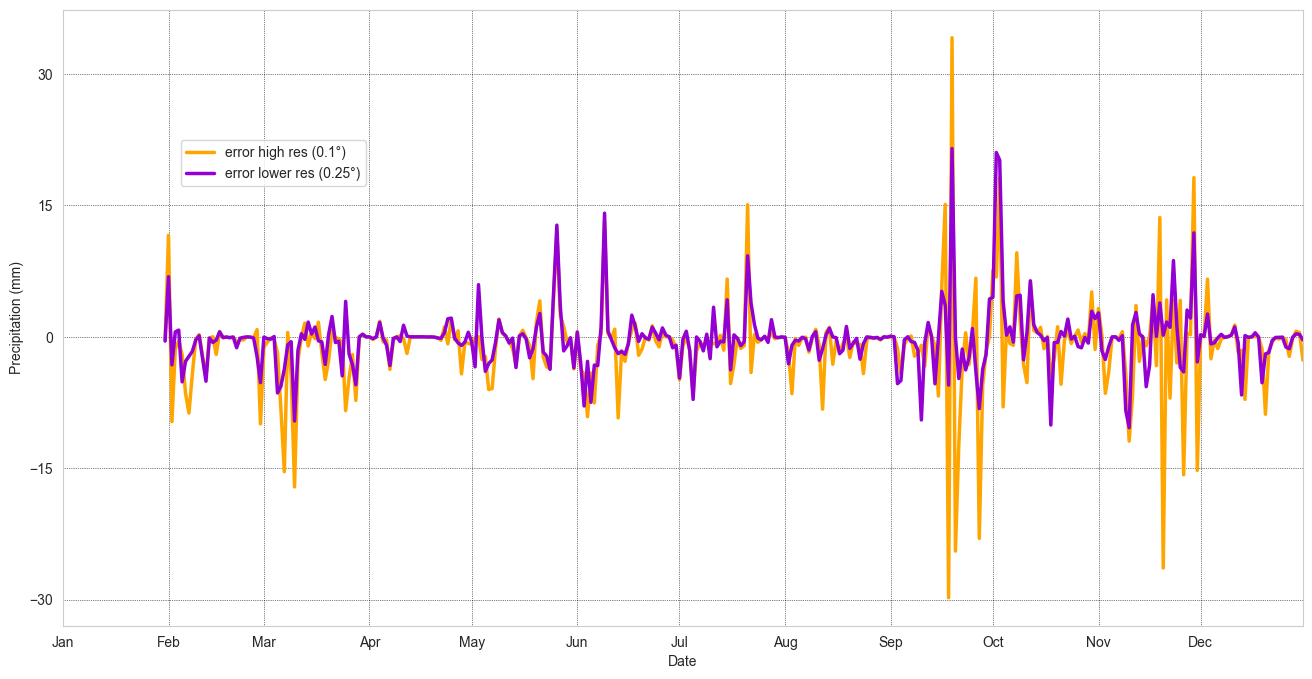

In [300]:
fig, ax1 = plt.subplots(figsize=(16, 8))

year = 1981

ax1.set_xlim([dt.date(year, 1, 1), dt.date(year, 12, 31)])
ax1.set_xlabel('Date')

ax1.xaxis.set_major_locator(mdt.MonthLocator())
ax1.xaxis.set_major_formatter(mdt.DateFormatter('%b'))

ax1.set_ylabel('Precipitation (mm)')
ax1.yaxis.set_major_locator(mtk.MaxNLocator(5))

ax1.grid(c='black', ls='dotted', lw=0.5)

#ax1.plot(rf_9to9_nrfa['Date'], rf_9to9_nrfa['Rain'], 'green', lw=2.5, ls='-', label='nrfa')
#ax1.plot(df_0_1['time'], df_0_1['tp']*100*24, 'orange', lw=2.5, ls='-', label='higher res (0.1°)')
#ax1.plot(df_0_25['time'], df_0_25['tp']*1000*24, 'darkviolet', lw=2.5, ls='-', label='lower res (0.25°)')

ax1.plot(combined_df['Date'], combined_df['Error_0.1'], 'orange', lw=2.5, ls='-', label='error high res (0.1°)')
ax1.plot(combined_df['Date'], combined_df['Error_0.25'], 'darkviolet', lw=2.5, ls='-', label='error lower res (0.25°)')

ax1.legend(loc=0, bbox_to_anchor=(0.25,0.8))

plt.show()

In [ ]:
date = (1981,11,11)

data_sep = data_sep.sel(time=dt.datetime(date[0], date[1], date[2]))
data_sep.tp.values

data_low_res = data_low_res.sel(time=dt.datetime(date[0], date[1], date[2]))
data_low_res.tp.values

In [210]:
import folium
import geopandas as gpd

lat_min = lat_min + 0.1
lon_max = lon_max - 0.1

def plot_with_folium(domain_data, catchment_polygon, date=(1981,1,1), value_column='variable', max_value=0.0025):
    '''
    Plots the spatial data using Folium with intensity based on values.

    Parameters
    ----------
    domain_data : xarray.Dataset
        The dataset containing spatial data.
    lon : float
        Longitude of the point to highlight.
    lat : float
        Latitude of the point to highlight.
    catchment_polygon : shapely.geometry.Polygon, optional
        Polygon representing the catchment area.
    value_column : str, optional
        The name of the column containing the values for intensity.
    '''
    
    points = catchment_polygon.centroid
    lat, lon = osg.BNG_2_latlon(points.x[0],points.y[0])
    
    print(lat, lon)
    
    # Extract data for the requested date
    data = domain_data.sel(time=dt.datetime(date[0], date[1], date[2]))

    # Convert the data to a pandas DataFrame
    df = data.to_dataframe().reset_index()

    # Initialize a Folium map
    m = folium.Map(location=[lat, lon], zoom_start=8)

    # Add the catchment polygon if provided
    gdf = catchment_polygon.to_crs("EPSG:4326")
    layer = folium.GeoJson(gdf, name='catchment').add_to(m)

    # Define a colormap
    colormap = folium.LinearColormap(colors=['blue', 'green', 'yellow', 'orange', 'red'],
                                     vmin=0,
                                     vmax=df[value_column].max())   # df[value_column].max() and min()

    df = df.dropna()

    # Add grid cells to the map
    for _, row in df.iterrows():
        lat = row['latitude']
        lon = row['longitude']
        value = row[value_column]
        color = colormap(value)
        folium.Rectangle(
            bounds=[(lat, lon), (lat-0.1, lon+0.1)],
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.2,
            popup=f"{value_column}: {value}"
        ).add_to(m)
    
    # Add colormap legend
    colormap.caption = value_column
    colormap.add_to(m)

    # Add a layer control
    folium.LayerControl().add_to(m)

    return m

station = 7001
domain_rain = xr.open_dataset(paths.WEATHER_UK + '/Rainfall_0.1/rainfall_aggregated_9to9_1981_0.1.nc')

#subset = domain_rain.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

subset = domain_rain.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

catchment_polygon = gpd.read_file(paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '.shp'))
max_value = 0.003
plot_with_folium(domain_data=subset, catchment_polygon=catchment_polygon, date=(1981,1,1), value_column='tp', max_value=max_value)

57.26631800813801 -4.102498204437348


<timed exec>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


1980-12-31T00:00:00.000000000
0.002806003936464816


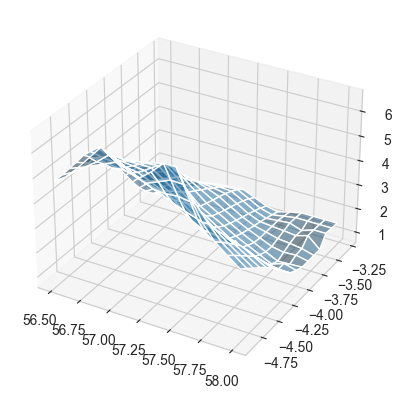

1981-01-01T00:00:00.000000000
0.0054998732286265055


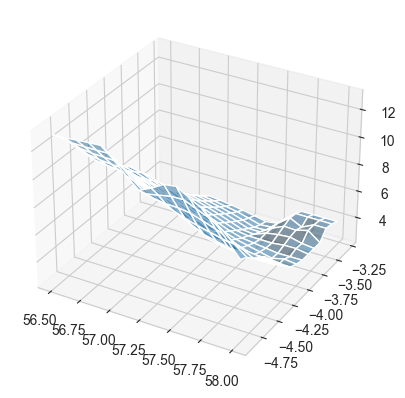

1981-01-02T00:00:00.000000000
0.022429889688967624


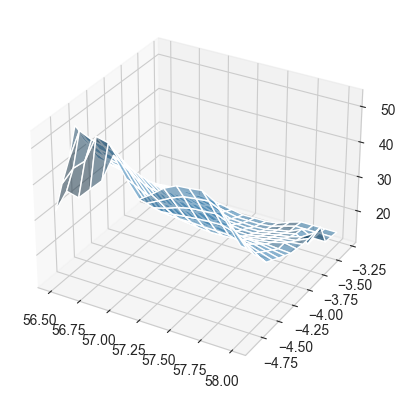

1981-01-03T00:00:00.000000000
0.004578463448553376


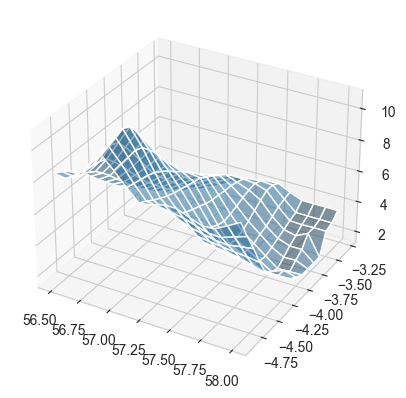

1981-01-04T00:00:00.000000000
0.003466753155944694


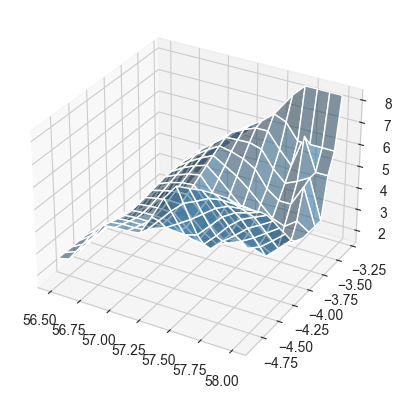

1981-01-05T00:00:00.000000000
0.003812658656170208


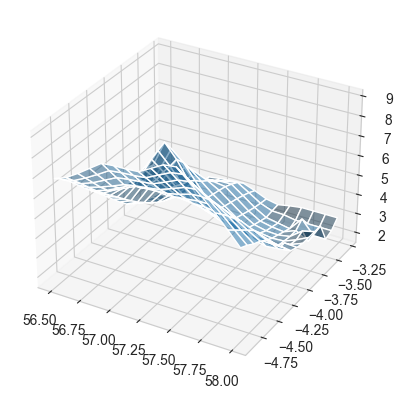

1981-01-06T00:00:00.000000000
0.0026916890458370244


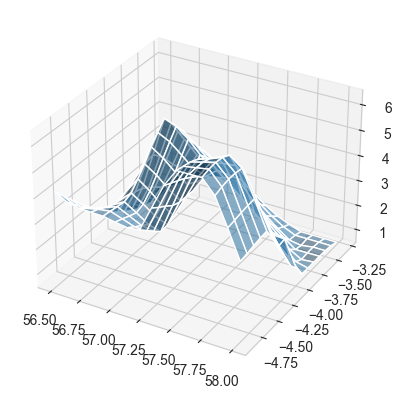

1981-01-07T00:00:00.000000000
0.0010510402282161587


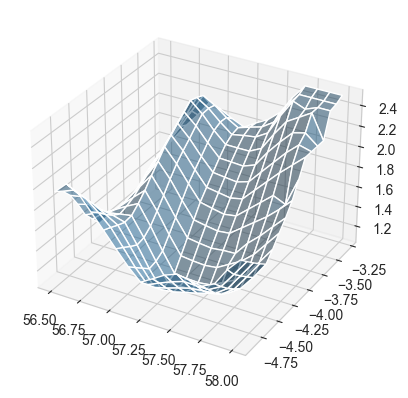

1981-01-08T00:00:00.000000000
0.002868235164892284


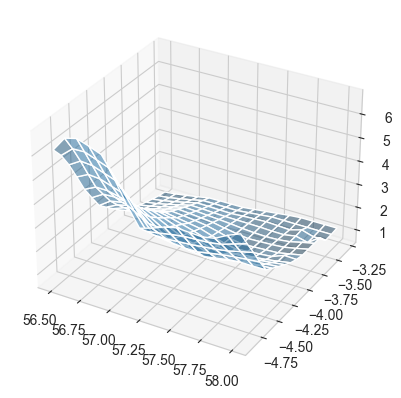

1981-01-09T00:00:00.000000000
0.004005273998136887


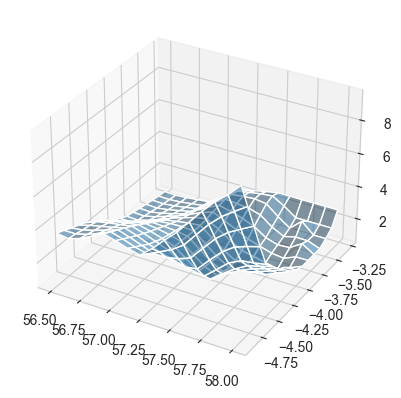

1981-01-10T00:00:00.000000000
0.0015560498768996149


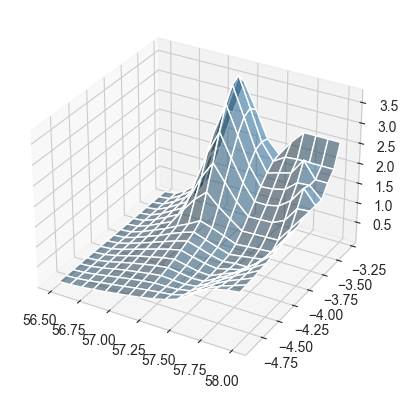

1981-01-11T00:00:00.000000000
0.0029792123944798487


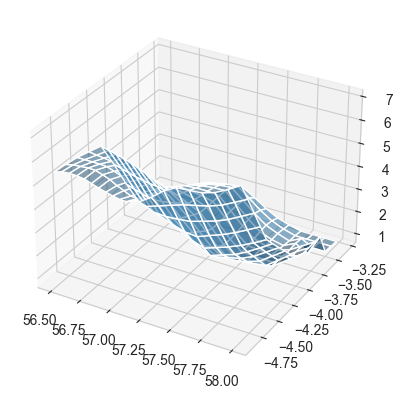

1981-01-12T00:00:00.000000000
0.005524340437381076


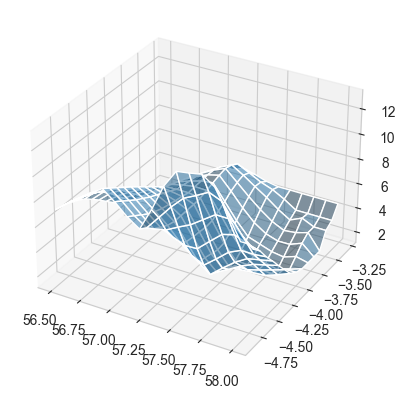

1981-01-13T00:00:00.000000000
0.005913581697886964


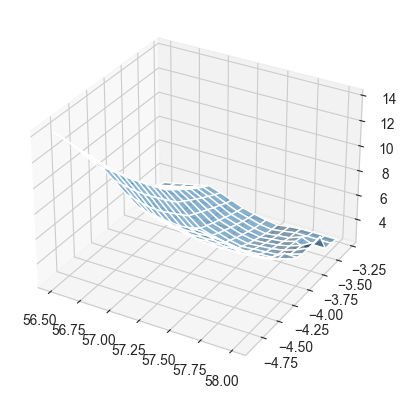

1981-01-14T00:00:00.000000000
0.012036870792261125


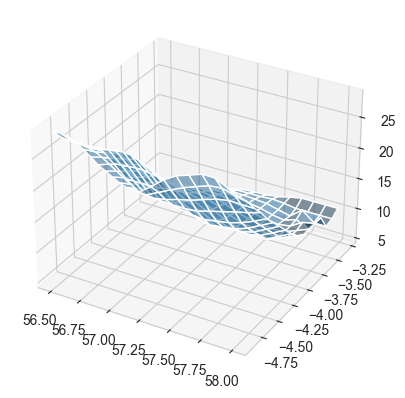

1981-01-15T00:00:00.000000000
0.0032246919806643236


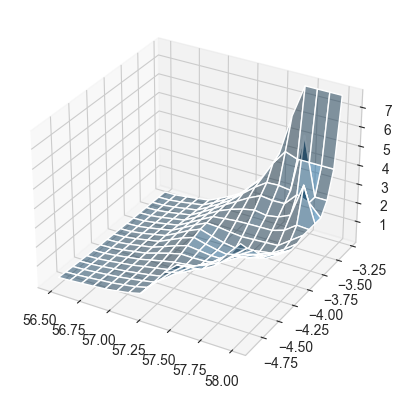

1981-01-16T00:00:00.000000000
0.0054209806116191925


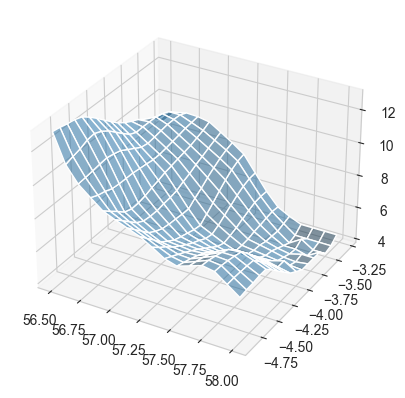

1981-01-17T00:00:00.000000000
0.003990416023183615


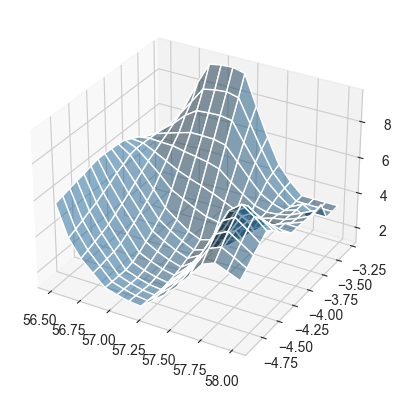

1981-01-18T00:00:00.000000000
0.004682280856877227


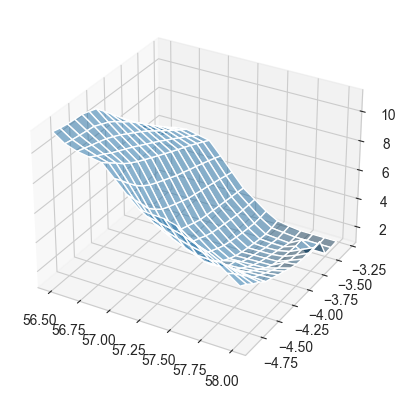

1981-01-19T00:00:00.000000000
0.006193945225266073


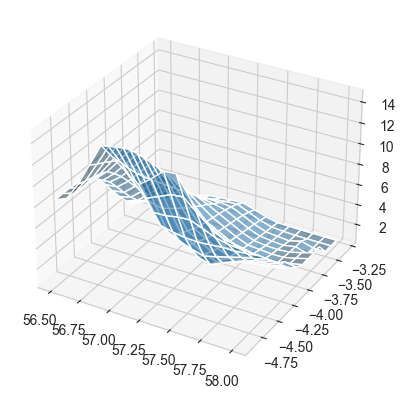

1981-01-20T00:00:00.000000000
0.0006133759660056809
1981-01-21T00:00:00.000000000
0.002966642332336411
1981-01-22T00:00:00.000000000
0.0016097485363774694
1981-01-23T00:00:00.000000000
0.0020348965696870935
1981-01-24T00:00:00.000000000
0.008307653662096605
1981-01-25T00:00:00.000000000
0.00184209281137137
1981-01-26T00:00:00.000000000
0.011369876916641465
1981-01-27T00:00:00.000000000
0.00012998036421982737
1981-01-28T00:00:00.000000000
0.0012764669315379767
1981-01-29T00:00:00.000000000
0.006145549140182775
1981-01-30T00:00:00.000000000
0.0005278887767817893
1981-01-31T00:00:00.000000000
0.00027791411484152467
1981-02-01T00:00:00.000000000
0.0024508660351360927
1981-02-02T00:00:00.000000000
0.010078659676635385
1981-02-03T00:00:00.000000000
0.006777712907850381
1981-02-04T00:00:00.000000000
0.0033738638958654595
1981-02-05T00:00:00.000000000
0.007943579442498884
1981-02-06T00:00:00.000000000
0.01379654490923591
1981-02-07T00:00:00.000000000
0.01968948155859179
1981-02-08T00:00:00.000

In [170]:
%%time

rain_data = xr.open_dataset(paths.WEATHER_UK + '/Rainfall_0.1/rainfall_aggregated_9to9_1981_0.1.nc')
rain_data

domain_rain = rain_data
RESOLUTION = 0.1

db = pd.read_csv(paths.DATA + '/Catchments_Fens.csv')
for i in [25]: #range(len(db)):
    db_path = paths.CATCHMENT_BASINS + '/' + str(db.loc[i][0])
    boundary_path = db_path + '/' + db.loc[i][4]
    
lat_min, lat_max, lon_min, lon_max = extract_raster_to_interpolate(boundary_path, RESOLUTION)
subset = domain_rain.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

interpolated_functions = interpolate_surface(subset)

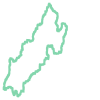

In [172]:
station_nr = 7001
catchment_polygon = gp.read_file(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '.shp'))
converted_polygon = convert_polygon(catchment_polygon.geometry.iloc[0], osg.BNG_2_latlon)
converted_polygon.boundary

In [197]:
%%time
from tqdm import tqdm

rain_columns = (['Rain'] + ['Rain-' + f'{d+1}' for d in range(27)])

rf_test = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_surf_interp.csv'), verbose=False)
rf_test['Date'] = pd.to_datetime(rf_test['Date'])
rf_test = rf_test.drop(columns=rain_columns)

# TODO : replace by selection per dates from 0.1 instead of the manual selection
start = 491
rf_test = rf_test[start:start+366]

# Compute total rainfall for each time step and store it in the DataFrame
tqdm.pandas()
rf_test['Rain'] = rf_test['Date'].progress_apply(
    lambda time: integrate_rainfall_over_polygon(converted_polygon, interpolated_functions[np.datetime64(time, 'ns')], resolution=0.05)
)
rf_test['Rain'] = rf_test['Rain'].astype('float64')

# Shift the data by 28 days for each day of rain
rf_test = hydropoint.weather_shift(rf_test, 'Rain', 28)

ext = '_9to9'
outpath = paths.CATCHMENT_BASINS + f'/{str(station_nr)}/{str(station_nr)}_lumped{ext}_surf_interp_0.1.csv'
print(outpath)
rf_test.to_csv(outpath, index=True)
rf_test

100%|██████████| 366/366 [00:27<00:00, 13.40it/s]


data/catchment_basins/7001/7001_lumped_9to9_surf_interp_0.1.csv
CPU times: total: 10.2 s
Wall time: 27.7 s


,Unnamed: 0.1,Unnamed: 0,Date,Flow,Temperature,U Windspeed,V Windspeed,Humidity,Snow Melt,Resultant Windspeed,...,Rain-18,Rain-19,Rain-20,Rain-21,Rain-22,Rain-23,Rain-24,Rain-25,Rain-26,Rain-27
521,551,730,1980-12-31,34.62,276.112427,6.112605,1.139384,77.726509,0.008705,6.217888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
522,552,731,1981-01-01,16.01,273.823440,4.731392,-0.635359,70.106891,5.110156,4.773861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523,553,732,1981-01-02,138.40,282.381552,4.187684,2.689574,97.827662,6.109870,4.976998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524,554,733,1981-01-03,31.72,277.895139,4.132638,-1.096704,90.304100,0.292973,4.275682,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
525,555,734,1981-01-04,15.82,272.569102,3.366670,-2.039481,85.420961,0.000000,3.936235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,912,1091,1981-12-27,16.21,275.962317,-2.717111,1.488435,84.857590,0.112476,3.098086,...,0.174614,0.256869,0.544313,2.406858,2.199229,3.550395,5.291353,0.323181,0.068141,14.920516
883,913,1092,1981-12-28,15.08,272.413502,-2.049097,-0.564459,85.916243,0.000000,2.125421,...,0.090646,0.174614,0.256869,0.544313,2.406858,2.199229,3.550395,5.291353,0.323181,0.068141
884,914,1093,1981-12-29,14.84,274.308173,-1.107085,-1.359625,91.890420,0.163469,1.753345,...,0.219120,0.090646,0.174614,0.256869,0.544313,2.406858,2.199229,3.550395,5.291353,0.323181
885,915,1094,1981-12-30,15.20,277.050184,-2.197397,-1.558990,94.237968,3.283934,2.694254,...,0.900485,0.219120,0.090646,0.174614,0.256869,0.544313,2.406858,2.199229,3.550395,5.291353


In [174]:
rf_test[['Date', 'Rain']]

,Date,Rain
521,1980-12-31,2.844652
522,1981-01-01,5.634321
523,1981-01-02,22.955438
524,1981-01-03,5.830368
525,1981-01-04,4.625590
...,...,...
882,1981-12-27,2.502361
883,1981-12-28,0.148624
884,1981-12-29,1.017007
885,1981-12-30,3.274951


In [175]:
rf_0_025 = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_surf_interp.csv'), verbose=False)
rf_0_025['Date'] = pd.to_datetime(rf_0_025['Date'])

# TODO : replace by selection per dates from 0.1 instead of the manual selection
start = 491
rf_res_0_25 = rf_0_025[start:start+366]

In [179]:
compare = rf_res_0_25[['Date', 'Rain']].merge(rf_test[['Date', 'Rain']], on='Date')
compare = compare.rename(columns={'Rain_x': 'Rain_0.25', 'Rain_y':'Rain_0.1'})
compare

,Date,Rain_0.25,Rain_0.1
0,1980-12-31,6.557405,2.844652
1,1981-01-01,4.924454,5.634321
2,1981-01-02,18.646844,22.955438
3,1981-01-03,5.001656,5.830368
4,1981-01-04,3.668246,4.625590
...,...,...,...
361,1981-12-27,1.913997,2.502361
362,1981-12-28,0.109959,0.148624
363,1981-12-29,0.804139,1.017007
364,1981-12-30,2.448233,3.274951


In [185]:
def year_plot(maxflow, df, y_pred, y_obsv, year, colour1='red',
              colour2='orange'):

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(df['Date'], df[y_pred], colour1, lw=2.5)
    ax.plot(df['Date'], df[y_obsv], colour2, lw=2.5)
    ax.set_xlabel('Date')
    ax.set_ylabel('Flow (m'+r'$^3$'+'s'+r'$^{-1}$'+')')
    ax.set_xlim([dt.date(year, 1, 1), dt.date(year, 12, 31)])
    ax.set_ylim(0,maxflow)
    ax.xaxis.set_major_locator(mdt.MonthLocator())
    ax.xaxis.set_major_formatter(mdt.DateFormatter('%b'))
    ax.yaxis.set_major_locator(mtk.MaxNLocator(5))
    ax.legend(['Higher Res', 'Lower Res'], loc='upper left')
    ax.grid(c='black', ls='dotted', lw=0.5)
    plt.show()


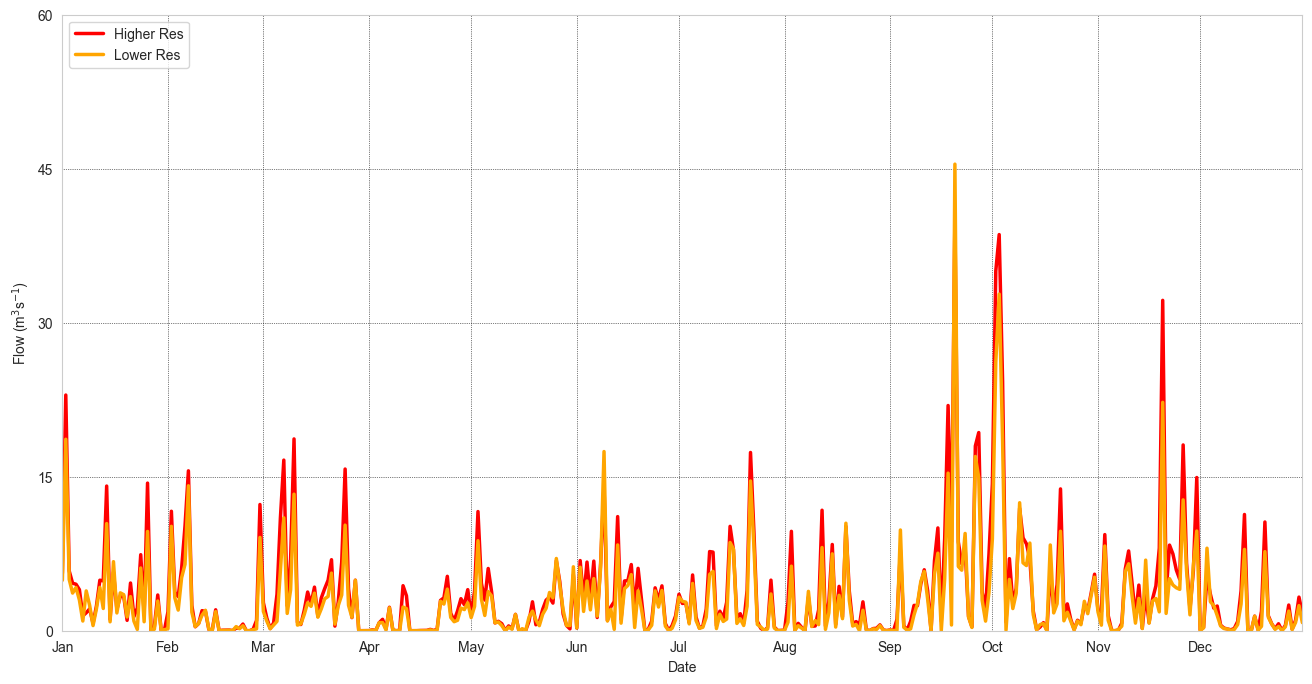

In [186]:
year_plot(60, compare, 'Rain_0.1', 'Rain_0.25', 1981)  